Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load & clean Data

In [10]:
data = pd.read_csv('data.csv',encoding = 'latin1')

In [11]:
data.shape

(15509, 10)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [13]:
data.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [14]:
data['Year']= data['Year'].str.extract('(\d{4})')
data['Year']= pd.to_numeric(data['Year'],errors='coerce')

In [15]:
data['Votes']= data['Votes'].str.replace(',','',regex=False)
data['Votes']= pd.to_numeric(data['Votes'],errors='coerce')

In [16]:
data.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7590
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

Explore Data

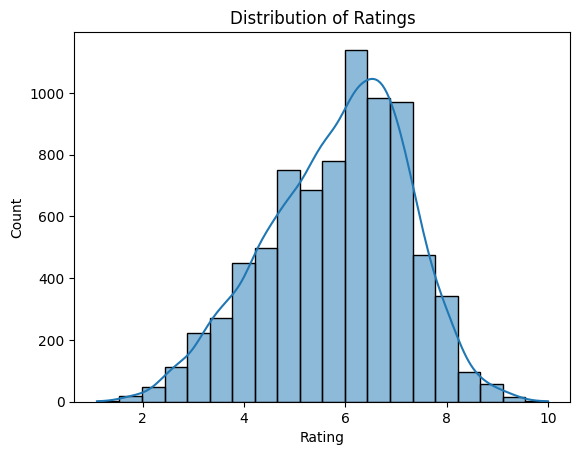

In [18]:
sns.histplot(data['Rating'].dropna(),kde=True,bins=20)
plt.title('Distribution of Ratings')
plt.show()

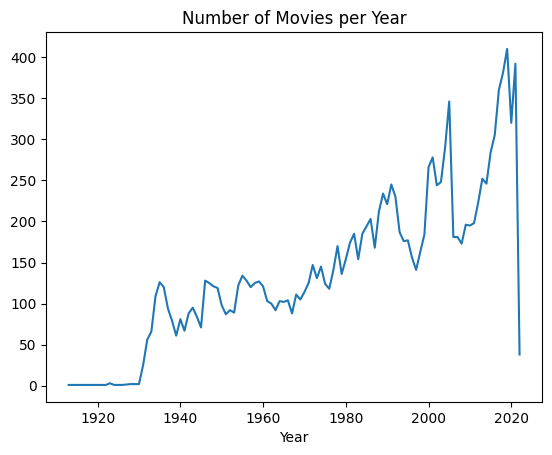

In [20]:
data['Year'].value_counts().sort_index().plot()
plt.title('Number of Movies per Year')
plt.show()

Handle Missing Data

In [21]:
data = data.dropna(subset=['Rating'])
for col in ['Genre','Director','Actor 1','Actor 2','Actor 3']:
    data[col] = data[col].fillna('Unknown')
data['Year'] = data['Year'].fillna(data['Year'].median())
data['Votes'] = data['Votes'].fillna(0)
print("Remaining missing values:\n",data.isnull().sum())

Remaining missing values:
 Name           0
Year           0
Duration    2068
Genre          0
Rating         0
Votes          0
Director       0
Actor 1        0
Actor 2        0
Actor 3        0
dtype: int64


Feature Engineering

In [22]:
data['Main_Genre'] = data['Genre'].apply(lambda x: x.split(',')[0].strip())

In [23]:
threshold = 10
director_counts = data['Director'].value_counts()
data['Director_clean'] = data['Director'].apply(lambda x: x if director_counts[x] >= threshold else 'Other')
actor_counts = data['Actor 1'].value_counts()
data['Actor1_clean'] = data['Actor 1'].apply(lambda x: x if actor_counts[x] >= threshold else 'Other')

In [24]:
data_encoded = pd.get_dummies(data, columns=['Main_Genre', 'Director_clean', 'Actor1_clean'], drop_first=True)

Build the Model

In [25]:
from sklearn.model_selection import train_test_split
features = ['Year', 'Votes'] + \
           [col for col in data_encoded.columns if col.startswith('Main_Genre_') or 
            col.startswith('Director_clean_') or col.startswith('Actor1_clean_')]
X = data_encoded[features]
y = data_encoded['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Models

Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Random Forest

In [28]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate Models

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")

print("Linear Regression:")
evaluate(lr, X_test, y_test)

print("\nRandom Forest:")
evaluate(rf, X_test, y_test)

Linear Regression:
RMSE: 1.21, R2: 0.22

Random Forest:
RMSE: 1.15, R2: 0.29


Insights

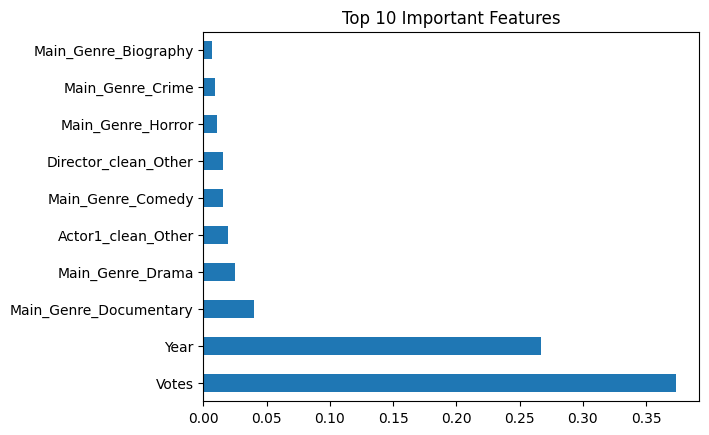

In [31]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

top_features.plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()
